# Sequence To Sequence Attention Models

One of the most coveted AI tasks is automatic machine translation (MT). In this task a sequence of words in a source language is translated into a sequence of words in a target language (usually those sequences are of different lengths). In order to succeed in this task, the model needs to generalize language patterns from a relatively small dataset of translated examples (the number of possible sentences in each language is large enough to be considered infinite).

Sequence to sequence neural models have been shown to make such generalizations for input and output of variable lengths. For example, [Bahdanau et al.2015] Neural Machine Translation by Jointly Learning to Align and Translate in ICLR 2015 (https://arxiv.org/abs/1409.0473) achieves nearly state-of-the-art results in MT.

In this tutorial, we solve a toy problem on a synthetic dataset to learn the reverse function (map "abcd" to "dcba") using the same models developed to solve MT.

The task we address is the following: the input is a random string $(c_0,c_1,c_2...c_n)$
of random length $n$ and the output is the reversed string $(c_n,c_{n−1},c_{n−2}...c_0)$

You can get an inspiration from the References, however, pay attention to the discrepancies in the implementation.

**References:**
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://talbaumel.github.io/blog/attention/
* https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb

In [ ]:
from random import choice, randrange
import string
from typing import Dict, Tuple, List, Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from torchtext.legacy import data
from torchtext.legacy import datasets

In [ ]:
from torchtext.legacy.data import Field
from torchtext.legacy.data import BucketIterator

# Data Generation

## Preparation

In [ ]:
chars = "abcd"
vocab = {ch: index for index, ch in enumerate(["<PAD>", "<BOS>", "<EOS>",  "<UNK>"] + list(chars))}

char2int = vocab
int2char = {value: key for key, value in vocab.items()}

print(char2int)
print()
print(int2char)

In [ ]:
def sample_model(min_length: int,
                 max_length: int,
                 chars: str = chars) -> Tuple[str, str]:
    """
    Generates a random string from given characters with length between
    min_length and max_length.
    Returns the generated string and its copy in reverse order.
    """
    random_length = randrange(min_length, max_length)
    random_char_list = [choice(chars) for _ in range(random_length)]
    random_string = "".join(random_char_list)
    return random_string, random_string[::-1]

Helper function to transform a sequence of letters into a sequence of indices

In [ ]:
def numerize(sequence: str, char_map: Dict[str, int] = char2int) -> List[int]:
    return [char_map.get(ch, char_map["<UNK>"]) for ch in sequence]

In [ ]:
numerize("abcdx", char2int)

Helper function to pad sequnces to max length. Sequnces longer than max length are kept without changes.

In [ ]:
def pad(sequence: List[str], max_length: int, char_map: Dict[str, int] = char2int) -> List[int]:
    num_pads = max(0, max_length - len(sequence))
    return sequence + [char_map["<PAD>"]] * num_pads

In [ ]:
pad([4, 5, 6, 7], max_length=10)

In [ ]:
pad([4, 5, 6, 7], max_length=2)

In [ ]:
pad([4, 5, 6, 7], max_length=4)

## Data for the model

To train an Encoder-Decoder Seq2Seq model we need three sequences: a sequence for encoder, a sequence for decoder, and a sequence for loss calculation (i.e. the sequence we want the model to predict).

The encoder sequence is the initial (source) sequence that we want "translate" (reverse in our case) with special beginning-of-sequence and end-of-sequnce tokens.

The decoder sequence is the "translation" with beginning-of-sequence token.

The target sequence is the "translation" with end-of-sequence token.

The reason for this is that we want to train the model to predict the _next_ token, given the current "translated" token and the encoded source sequnce.

For example, let's say we have the following sequences:

`1) <BOS>abcd<EOS>`

`2) <BOS>dcba`

`3) dcba<EOS>`

So given the encoding of `(1)` and `<BOS>` we want to predict `d`, then given the encoding of `(1)` and `<BOS>d` we want to predict `c`, and so on.

The function below generates examples in _batches_, so in needs to pad all examples to the same max length with `<PAD>` token as well. For a single example no padding is necessary.

In [ ]:
def generate_batch(min_length: int,
                   max_length: int,
                   batch_size: int,
                   int2char: Dict[int, str] = int2char,
                   char2int: Dict[str, int] = char2int) -> torch.Tensor:
    """
    Generates `batch_size` examples.
    Returns:
        encoder_seq: tensor of size `(batch_size, max_length)` containing original sequence with <BOS> and <EOS> tags
        decoder_seq: tensor of size `(batch_size, max_length)` containing reversed sequence with <BOS> tag
        target_seq: tensor of size `(batch_size, max_length)` containing reversed sequence with <EOS> tag
    """
    
    examples = [sample_model(min_length, max_length)
                 for _ in range(batch_size)]
    
    encoder_seq, decoder_seq, target_seq = [], [], []
    
    for original, reverse in examples:
        encoder_seq.append(pad(sequence=[char2int["<BOS>"]] + numerize(original) + [char2int["<EOS>"]],
                                 max_length=max_length + 1))
        decoder_seq.append(pad(sequence=[char2int["<BOS>"]] + numerize(reverse),
                                 max_length=max_length + 1))
        target_seq.append(pad(sequence=numerize(reverse) + [char2int["<EOS>"]], 
                                 max_length=max_length + 1))
            
        
    encoder_seq = torch.Tensor(encoder_seq).long()
    decoder_seq = torch.Tensor(decoder_seq).long()
    target_seq = torch.Tensor(target_seq).long()
    
    return encoder_seq, decoder_seq, target_seq

Let us generate a couple examples:

In [ ]:
print(sample_model(4, 5))
print(sample_model(5, 10))

In [ ]:
encoder_seq, decoder_seq, target_seq = generate_batch(min_length=5, max_length=10, batch_size=4)
for encoder_item, decoder_item, target_item in zip(encoder_seq, decoder_seq, target_seq):
    print()
    print("encoder input:", encoder_item)
    print("decoder input:", decoder_item)
    print("target output:", target_item)
    print()

We define a train function to optimize a model on our training dataset and plot training errors as learning proceeds. The sets are generated while training.

In [ ]:
from IPython.display import clear_output

def run_experiment(model,
                   criterion,
                   optimizer,
                   scheduler,
                   device,
                   min_length,
                   max_length,
                   batch_size,
                   num_steps,
                   plot_every):

    losses = []

    model.train()

    for index in tqdm(range(num_steps)):
        encoder_seq, decoder_seq, target_seq = generate_batch(min_length, max_length, batch_size)
        pred = model(encoder_seq.to(device), decoder_seq.to(device))
        loss = criterion(pred.view(-1, pred.size(-1)), target_seq.to(device).view(-1))
        losses.append(loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        if index and index % plot_every == 0:
            clear_output()
            plt.figure(figsize=(8, 5))
            plt.plot(losses)
            plt.grid()
            plt.show()
    clear_output()
    plt.figure(figsize=(8, 5))
    plt.plot(losses)
    plt.grid()
    plt.show()

## 1 . Implement the Encoder-Decoder Model (45 points)

We will now try to solve our problem using the encoder-decoder model. An encoder RNN will read the entire input string and generate a fixed length encoded vector to represent the entire input string. The decoder will then use the encoded string to predict the output.

This strategy should address the concern that to generate a reverse string properly we should first look at the whole input string - then start generating.

Naturally, we are still skeptical: can it be that the encoder will "remember" the input string sufficiently to generate the whole output strings? Let us try it.

<img src="https://talbaumel.github.io/blog/attention/img/encdec.jpg" width=700>

Complete the implementation of the `Encoder`, `Decoder` and `BasicSeq2Seq`.

**You may change the details of the implementation (such as parameters of the classes), however, make sure to account for the changes in the later tasks.**

In [ ]:
# adjustable parameters
INPUT_DIM = len(char2int)
OUTPUT_DIM = len(char2int)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

### Encoder

In [ ]:
# Implement this model

class Encoder(nn.Module):
    # This is just for reference, so change it if necessary
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 padding_index: int,
                 rnn: nn.Module = nn.LSTM,
                 num_layers:int = 2,
                 hidden_size: int = 64,
                 bidirectional: bool = True
                 ):
    #def __init__(self, input_dim: int, emb_dim: int, hid_dim: int, n_layers: int, dropout: float):
        super().__init__()
        self.emb_dim = emb_dim
        self.vocab_size = vocab_size
        self.padding_index =  padding_index
        self.num_layers = num_layers
        self.bidirectional =  bidirectional
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_size, num_layers, bidirectional = bidirectional)

    def forward(self, src_batch: torch.LongTensor):
        """

        Parameters
        ----------
        src_batch : 2d torch.LongTensor
            Batched tokenized source sentence of shape [sent len, batch size].

        Returns
        -------
        hidden, cell : 3d torch.LongTensor
            Hidden and cell state of the LSTM layer. Each state's shape
            [n layers * n directions, batch size, hidden dim]
        """
        embedded = self.embedding(src_batch) # [sent len, batch size, emb dim]
        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs -> [sent len, batch size, hidden dim * n directions]
        return hidden, cell

### Decoder

In [ ]:
# Implement the model
# Again, existing code is just for reference
# Change it as you wish
class Decoder(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 hidden_size: int,
                 output_dim: int,
                 n_layers: int,
                 rnn: nn.Module = nn.LSTM,
                 padding_index: int = 0,
                 head: bool = True
                 ):

        super(Decoder, self).__init__()

        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.n_layers = n_layers
        self. head =  head

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hidden_size, n_layers, dropout= head)
        self.out = nn.Linear(hidden_size, output_dim, bias  = head)

    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        
        #output = [seq len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #seq len and n directions will always be 1 in the decoder, therefore:
        #output = [1, batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

## BasicSeq2Seq

In [ ]:
# Implement the model
# Here you just need to connect previously implemented Encoder and Decoder classes
class BasicSeq2Seq(nn.Module):
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 hidden_size: int,
                 output_dim: int,
                 n_layers: int,
                 rnn: nn.Module = nn.LSTM,
                 padding_index: int = 0):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.emb_dim = emb_dim
        self.hidden_size = hidden_size
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.device = device

        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        for t in range(1, trg_len):
            
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input, hidden, cell)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
        
        return outputs

### Experiments:

Run some experiments. Try changing the parameters to see how it affects the model.

In [ ]:
batch_size = 256
lr = 1e-2
min_length = 5
max_length = 12
train_num_steps = 2000
plot_every = 250

emb_dim=8
hidden_size=128
vocab_size=len(char2int)
num_layers=1
bidirectional=False
padding_index=char2int["<PAD>"]

device = torch.device('cuda')

model = BasicSeq2Seq(emb_dim,
                     vocab_size,
                     hidden_size,
                     num_layers,
                     bidirectional,
                     padding_index).to(device)

In [ ]:
model

BasicSeq2Seq()

In [ ]:
criterion = torch.nn.CrossEntropyLoss(reduction="sum", ignore_index=char2int["<PAD>"])

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 0 trainable parameters


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

ValueError: ignored

In [ ]:
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda step: 0.9995)

NameError: ignored

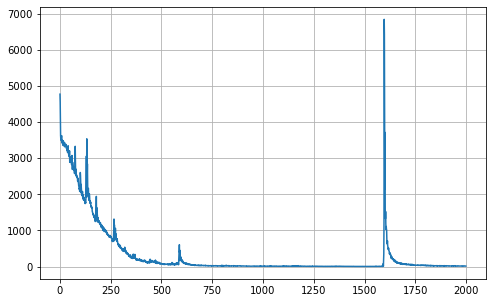

In [ ]:
run_experiment(model=model,
               criterion=criterion,
               optimizer=optimizer,
               scheduler=scheduler,
               min_length=min_length,
               max_length=max_length,
               batch_size=batch_size,
               num_steps=train_num_steps,
               plot_every=plot_every,
               device=device)

## Evaluation

The following function implements a greedy algorithm to generate the output of the model. Note that we only use encoder and decoder sequence here.

In [ ]:
def generate_output(source, model, device, char_map, reverse_char_map):

    numerized = [char_map["<BOS>"]] + numerize(source, char_map=char_map) + [char_map["<EOS>"]]

    encoder_sequence = torch.tensor([numerized]).long().to(device)
    # we start the process of generation with just the <BOS> token
    decoder_sequence = torch.tensor([char_map["<BOS>"]]).long().unsqueeze(0).to(device)

    model.eval()

    with torch.no_grad():
        # the number of steps may be different, however in this case we know that the lenghts should be same
        for timestamp in range(len(source)): 
            predictions = model(encoder_sequence, decoder_sequence)
            # get the index of the most likely token
            current_token = predictions[:, -1, :].argmax(dim=-1)
            if current_token == char_map["<EOS>"]:
                break
            # append the predicted token to the decoder sequence if it's not <EOS> 
            decoder_sequence = torch.cat([decoder_sequence, current_token.unsqueeze(0)], dim=-1)

    output = decoder_sequence.squeeze(0).tolist()
    output = [reverse_char_map[index] for index in output]
    output = "".join(output).lstrip('<BOS> ').rstrip('<EOS>')

    return output

In [ ]:
generate_output("abcd", model, device, char2int, int2char)

'dcba'

In [ ]:
sequences = ['abcd',
             'abba',
             'abcdbca',
             'aabbccdd',
             'abacadaba',
             'abcdabcdabcdabcd']


for seq in sequences:
    pred = generate_output(seq, model, device, char2int, int2char)
    print("String:", seq,
          'Gold:', seq[::-1],
          'Predicted:', pred,
          'Correct:', str(seq[::-1] == pred))

String: abcd Gold: dcba Predicted: dcba Correct: True
String: abba Gold: abba Predicted: abba Correct: True
String: abcdbca Gold: acbdcba Predicted: acbbcda Correct: False
String: aabbccdd Gold: ddccbbaa Predicted: ddccbbaa Correct: True
String: abacadaba Gold: abadacaba Predicted: abadacaba Correct: True
String: abcdabcdabcdabcd Gold: dcbadcbadcbadcba Predicted: dcbacdabdcdabca Correct: False


In [ ]:
short_strings = [sample_model(5, 10) for _ in range(100)]
medium_strings = [sample_model(10, 15) for _ in range(100)]
long_strings = [sample_model(15, 25) for _ in range(100)]

def count_matches(model, val_set, device, char2int, int2char):
    matches = [generate_output(source=input_string,
                               model=model,
                               device=device,
                               char_map=char2int,
                               reverse_char_map=int2char) == output_string for input_string, output_string in val_set]
    return matches.count(True)

print('Matches for short strings', count_matches(model, short_strings, device, char2int, int2char))
print('Matches for medium strings', count_matches(model, medium_strings, device, char2int, int2char))
print('Matches for long strings', count_matches(model, long_strings, device, char2int, int2char))

Matches for short strings 40
Matches for medium strings 60
Matches for long strings 0


You may see that the model doesn't do very well on longer sequnces.

## 2. Implement the Attention Model (45 points)

### _You may choose to implement either Bahdanau Attention or Scaled Dot Product Attention_

### Bahdanau Attention

The attention model was introduced to address the limitation:

    How does the decoder know which part of the encoding is relevant at each step of the generation.
    How can we overcome the limited memory of the encoder so that we can "remember" more of the encoding process than a single fixed size vector.

The attention model comes between the encoder and the decoder and helps the decoder to pick only the encoded inputs that are important for each step of the decoding process.

<img src="https://talbaumel.github.io/blog/attention/img/att.jpg" width=500>

For each encoded input from the encoder RNN, the attention mechanism calculates its importance:

$importance_{ij}=V∗tanh(encodedInput_iW_1+decoderstate_jW_2)$

$importance_{ij}$ is the importance of encoded vector $i$ at decoding step $j$


$W_1$, $W_2$ and $V$ are learned parameters

Once we calculate the importance of each encoded vector, we normalize the vectors with softmax and multiply each encoded vector by its weight to obtain a "time dependent" input encoding which is fed to each step of the decoder RNN.

Note that in this model, the attention mechanism computes a fixed-size vector that encodes the whole input sequence based on the sequence of all the outputs generated by the encoder (as opposed to the encoder-decoder model above which was looking ONLY at the last state generated by the encoder for all the slices of the decoder).

### Scaled Dot Product Attention

For details consult `Attention is all you need` paper.

![image.png](attachment:ab2f7a89-aa44-48d8-b89e-ad3cdf990475.png)


<img src="https://www.paperswithcode.com/media/methods/SCALDE.png">



### Implement attention mechanism as a class or a function

In [ ]:
# You may choose to implement scaled dot product attention or stick with Bahdanau attention if you wish

def scaled_dot_product_attention(query: torch.Tensor,
                                 key: torch.Tensor,
                                 value: torch.Tensor,
                                 mask: Optional[torch.Tensor] = None) -> torch.Tensor:

        # Your code here
        ################################





        ################################

### Implement a Seq2Seq model with attention

In [ ]:
class AttentionSeq2Seq(nn.Module):
    
    def __init__(self,
                 vocab_size: int,
                 emb_dim: int,
                 hidden_size: int,
                 num_layers: int,
                 bidirectional: bool,
                 padding_index: int):

        super(AttentionSeq2Seq, self).__init__()

        # Your code here
        ################################

        # Here you should put your encoder and decoder
        # (modified if necessary)




        ################################

        # consider saving last attention similarity
        # matrix for visualization
        self.last_similarity_matrix = None

    def forward(self, encoder_seq, decoder_seq):

        # Your code here
        ################################


        # Here you should implement some variant
        # of attention between encoder and decoder





        ################################

        return self.fc(output)

In [ ]:
batch_size = 256
lr = 1e-2
min_length = 6
max_length = 18
train_num_steps = 1000
plot_every = 250

device = torch.device('cuda')

model = AttentionSeq2Seq(emb_dim=8,
                         vocab_size=len(char2int),
                         hidden_size=256,
                         num_layers=1,
                         bidirectional=True,
                         padding_index=char2int["<PAD>"]).to(device)

criterion = torch.nn.CrossEntropyLoss(reduction="sum", ignore_index=char2int["<PAD>"])
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda step: 0.9995)

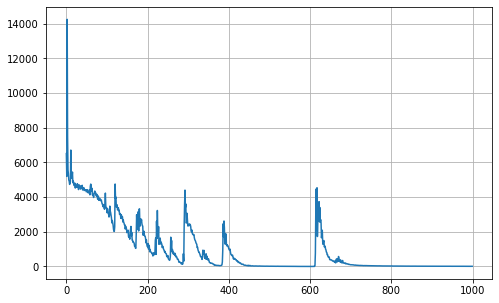

In [ ]:
run_experiment(model=model,
               criterion=criterion,
               optimizer=optimizer,
               scheduler=scheduler,
               min_length=min_length,
               max_length=max_length,
               batch_size=batch_size,
               num_steps=train_num_steps,
               plot_every=plot_every,
               device=device)

In [ ]:
generate_output("abcd", model, device, char2int, int2char)

'dcba'

In [ ]:
generate_output("abcdabcdabcdabcd", model, device, char2int, int2char)

'dcbadcbadcbadcba'

In [ ]:
sequences = ['abcd',
             'abba',
             'abcdbca',
             'aabbccdd',
             'abacadaba',
             'abcdabcdabcdabcd']


for seq in sequences:
    pred = generate_output(seq, model, device, char2int, int2char)
    print("String:", seq,
          'Gold:', seq[::-1],
          'Predicted:', pred,
          'Correct:', str(seq[::-1] == pred))

String: abcd Gold: dcba Predicted: dcba Correct: True
String: abba Gold: abba Predicted: abba Correct: True
String: abcdbca Gold: acbdcba Predicted: acbdcba Correct: True
String: aabbccdd Gold: ddccbbaa Predicted: ddccbbaa Correct: True
String: abacadaba Gold: abadacaba Predicted: abadacaba Correct: True
String: abcdabcdabcdabcd Gold: dcbadcbadcbadcba Predicted: dcbadcbadcbadcba Correct: True


In [ ]:
short_strings = [sample_model(5, 10) for _ in range(100)]
medium_strings = [sample_model(10, 15) for _ in range(100)]
long_strings = [sample_model(15, 25) for _ in range(100)]

def count_matches(model, val_set, device, char2int, int2char):
    matches = [generate_output(source=input_string,
                               model=model,
                               device=device,
                               char_map=char2int,
                               reverse_char_map=int2char) == output_string for input_string, output_string in val_set]
    return matches.count(True)

print('Matches for short strings', count_matches(model, short_strings, device, char2int, int2char))
print('Matches for medium strings', count_matches(model, medium_strings, device, char2int, int2char))
print('Matches for long strings', count_matches(model, long_strings, device, char2int, int2char))

Matches for short strings 100
Matches for medium strings 100
Matches for long strings 50


Notice the improvement in performance.

## 3. Visualize the attention weights (10 Points)

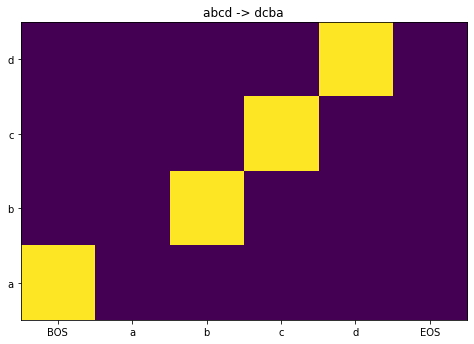

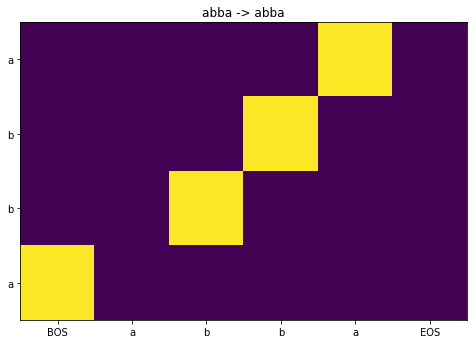

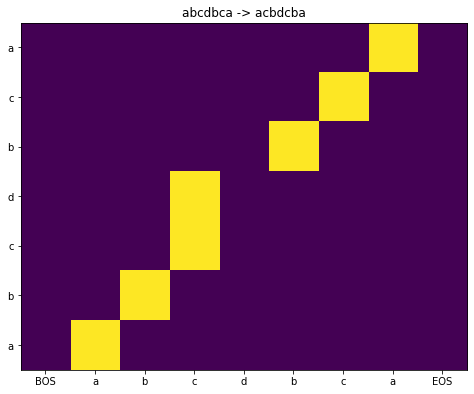

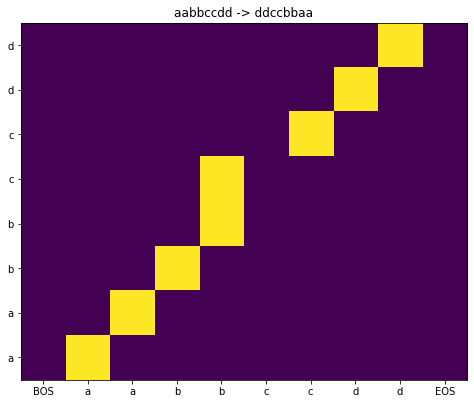

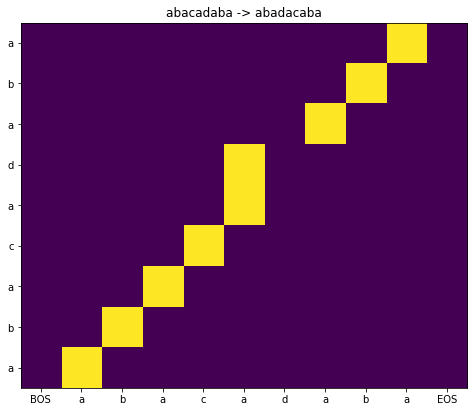

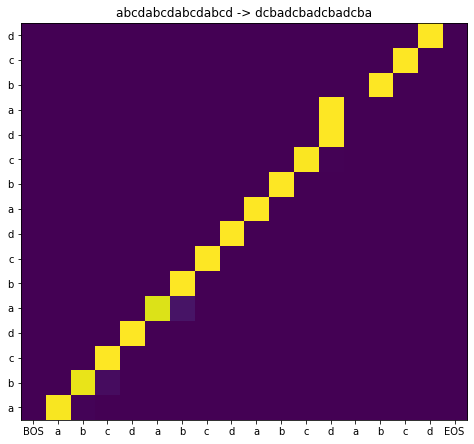

In [ ]:
def plot_results(model, sequence):
        # Your code here
        ################################





        ################################

sequences = ['abcd',
             'abba',
             'abcdbca',
             'aabbccdd',
             'abacadaba',
             'abcdabcdabcdabcd']

for sequence in sequences:
    plot_results(model, sequence)

## References:
* https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html
* https://talbaumel.github.io/blog/attention/
* https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb